## Fine-tuning DeBERTa-v3

In this notebook, I will fine-tune the entire DeBERTa-v3 model specifically for the disaster tweet classification task.

Fine-tuning allows the model's internal weights to adapt to the specific vocabulary and nuances of the disaster dataset, potentially capturing complex linguistic patterns that static embeddings might miss.

In [1]:
import zipfile

zip_path = "data/nlp-getting-started.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("data")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
import torch
import numpy as np
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df.isna().sum(), df.shape

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 (7613, 5))

In [7]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

<Axes: xlabel='target'>

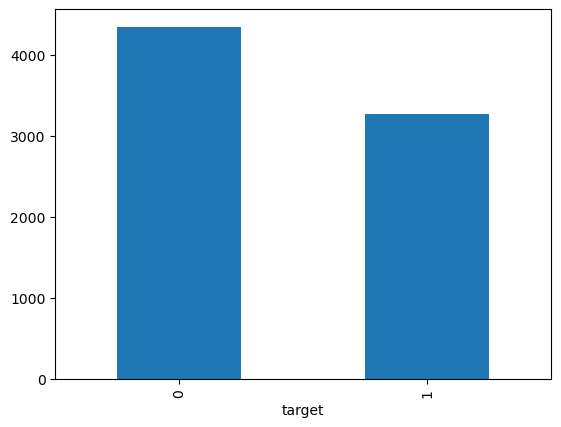

In [8]:
df['target'].value_counts().plot(kind="bar")

Dataset Preparation

- The pandas DataFrames are converted into Hugging Face `Dataset` objects.

- The training dataset is split into training and validation subsets.

In [9]:
from datasets import Dataset, DatasetDict

raw_datasets = Dataset.from_pandas(df)
raw_test_datasets = Dataset.from_pandas(df_test)

dataset = DatasetDict({
    "train": raw_datasets,
    "test": raw_test_datasets
})

In [ ]:
split = dataset["train"].train_test_split(test_size=0.2, seed=42)

dataset = DatasetDict({
    "train": split["train"],
    "validation": split["test"],
    "test": dataset["test"]
})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 6090
    })
    validation: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target'],
        num_rows: 1523
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text'],
        num_rows: 3263
    })
})

### Tokenizer and Model

I used DeBERTa-v3-base as the backbone model.

Reasons for this choice:
- strong performance on NLP classification tasks
- efficient attention mechanism
- availability of high-quality pretrained weights

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenization
Text data must be converted into numerical representations.

The tokenization function:
- truncates long sequences
- prepares inputs compatible with the Transformer model

This function will be applied to the entire dataset in a batched manner.


In [12]:
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    validation: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'target', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3263
    })
})

In [13]:
tokenized_dataset["train"] = tokenized_dataset["train"].rename_column("target", "labels")
tokenized_dataset["validation"] = tokenized_dataset["validation"].rename_column("target", "labels")

In [14]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    validation: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3263
    })
})

### Dynamic Padding with DataCollator
Instead of padding all sequences to a fixed maximum length,
we use a `DataCollatorWithPadding`.

This approach:
- pads sequences dynamically per batch
- reduces unnecessary computation
- improves training efficiency


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [16]:
# check about DataCollatorWithPadding
samples = tokenized_dataset["train"][:10]
samples = {k:v for k, v in samples.items() if k not in ['id','keyword','location','text']}
[len(x) for x in samples['input_ids']]

[23, 37, 36, 28, 50, 31, 33, 57, 44, 11]

In [17]:
batch = data_collator(samples)
{k:v.shape for k, v in batch.items()}

{'labels': torch.Size([10]),
 'input_ids': torch.Size([10, 57]),
 'token_type_ids': torch.Size([10, 57]),
 'attention_mask': torch.Size([10, 57])}

### Training Configuration
Training behavior is controlled using `TrainingArguments`, including:
- batch size
- learning rate
- number of epochs
- evaluation strategy


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer",
                                  eval_strategy="epoch",
                                  save_strategy="no",
                                  per_device_train_batch_size=4,
                                  per_device_eval_batch_size=4,
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  num_train_epochs=2,
                                  report_to="none",
                                  seed=42,
                                  data_seed=42)

In [19]:
import numpy as np
import evaluate 
def compute_metrics(eval_preds):
    metrics = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metrics.compute(predictions=predictions, references=labels)

### Trainer Setup
The Hugging Face `Trainer` class is used to abstract:
- training loop
- evaluation

In [20]:
from transformers import Trainer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Fine-tuning the Transformer Model

At this stage, I fine-tune a pretrained DeBERTa-v3-base model on the disaster tweet classification task.


In [21]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
/opt/anaconda3/envs/llm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.546000,0.486545,0.824688,0.785886
2,0.462000,0.561648,0.841760,0.807046


/opt/anaconda3/envs/llm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=3046, training_loss=0.5196290620439395, metrics={'train_runtime': 893.5945, 'train_samples_per_second': 13.63, 'train_steps_per_second': 3.409, 'total_flos': 284467207889808.0, 'train_loss': 0.5196290620439395, 'epoch': 2.0})

In [22]:
predictions = trainer.predict(tokenized_dataset["test"])

/opt/anaconda3/envs/llm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [23]:
preds = np.argmax(predictions.predictions, axis=-1)

In [24]:
submit = pd.read_csv("data/sample_submission.csv")
submit.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [25]:
submit["target"] = preds

In [26]:
submit.to_csv("submit_folder/fine_tune_result.csv", index=False)